# Business Understanding

Tujuan umum dari analisis dataset ini adalah untuk memahami variabel apa yang mempengaruhi biaya asuransi. Tujuan lain adalah untuk menentukan apakah kita dapat memprediksi biaya asuransi berdasarkan variabel tambahan seperti usia, jenis kelamin, berat badan tubuh (BMI), jumlah anak, status perokok, dan lokasi tempat tinggal.

Dengan melakukan analisis data dari kumpulan data ini, kita dapat mendapatkan informasi seperti pengaruh usia, status perokok, dan indeks massa tubuh (BMI) terhadap biaya asuransi. Kita juga dapat melakukan regresi untuk memprediksi biaya asuransi berdasarkan metrik ini.

# Data Understanding

Dataset ini biasanya terdiri dari beberapa kolom yang mewakili berbagai atribut atau fitur. Beberapa kolom umum yang biasanya ada dalam dataset asuransi mencakup:

- age: Usia.
- sex: Jenis kelamin.
- bmi: Indeks Massa Tubuh (BMI).
- children: Jumlah anak/anak-anak dalam tanggungan.
- smoker: Status perokok.
- region: Wilayah tempat tinggal atau terdaftar.
- charges: Biaya asuransi yang dibayarkan.

**Pyspark Set Up**

In [265]:
!pip install pyspark


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [266]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, when
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [267]:
spark = SparkSession.builder.appName("Asuransi").getOrCreate()

## Data Preparation

In [268]:
df = spark.read.csv("insurance.csv", header=True, inferSchema=True)
df.toPandas()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Dataset ini terdiri dari 1338 baris data dengan banyaknya variabel terdapat 6 variabel independen(yang mempengaruhi) dan 1 variabel dependen(target/dipegaruhi)

In [269]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [270]:
df.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  NULL|30.663396860986538|  1.0949177877429|  NULL|     NULL|13270.422265141257|
| stddev|14.049960379216147|  NULL| 6.098186911679012|1.205492739781914|  NULL|     NULL|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



Dari deskripsi di atas, terdapat asumsi adanya outlier pada variabel anak di mana rata-rata nasabah asuransi memiliki satu anak, namun ada nasabah yang memiliki 5 anak. Selain itu, pada variabel charges juga terdapat indikasi adanya outlier yaitu pada nilai max mencapai 63 ribu yang mana jauh dari rata-rata. Hal ini perlu dilakukan analisis lebih lanjut pada tahapan EDA. Selain itu, terlihat tidak adanya data kosong pada tiap varibel nya dengan jumlah data masing masing variabel sebanyak 1338 data.

## Data Duplikat

In [271]:
duplicate_rows = df.groupBy(df.columns).count().filter(col("count") > 1)
duplicate_rows.show()


+---+----+-----+--------+------+---------+---------+-----+
|age| sex|  bmi|children|smoker|   region|  charges|count|
+---+----+-----+--------+------+---------+---------+-----+
| 19|male|30.59|       0|    no|northwest|1639.5631|    2|
+---+----+-----+--------+------+---------+---------+-----+



Terdapat 1 baris data duplikat sehingga perlu dihapus untuk mengoptimalkan model regresi yang akan dibuat. Menghapus data duplikat penting dalam banyak kasus untuk memastikan kualitas data dan akurasi analisis atau model yang dibangun.


In [272]:
df = df.dropDuplicates()

In [273]:

duplicate_rows = df.groupBy(df.columns).count().filter(col("count") > 1)
duplicate_rows.show()


+---+---+---+--------+------+------+-------+-----+
|age|sex|bmi|children|smoker|region|charges|count|
+---+---+---+--------+------+------+-------+-----+
+---+---+---+--------+------+------+-------+-----+



# Feature Engineering


### 1. Mengubah jenis kelamin menjadi binary value

In [274]:
sex = df.groupBy("sex").count()
sex.show()

+------+-----+
|   sex|count|
+------+-----+
|female|  662|
|  male|  675|
+------+-----+



Dalam dataset ini terdapat 662 nasabah wanita dan 675 nasabah pria. Hal ini menunjukan perbandingan nasabah pria dan wanita hampir seimbang. Tahapapn selanjutnya saya ingin mengubah nilai pria menjadi 1 dan wanita menjadi 0

In [275]:
df = df.withColumn('sex_binary', when(df['sex'] == 'male', 1).otherwise(0))
df = df.drop('sex')
df.show()

+---+------+--------+------+---------+-----------+----------+
|age|   bmi|children|smoker|   region|    charges|sex_binary|
+---+------+--------+------+---------+-----------+----------+
| 60|  39.9|       0|   yes|southwest|  48173.361|         1|
| 40|26.315|       1|    no|northwest| 6389.37785|         1|
| 54|  30.8|       3|    no|southwest|   12105.32|         0|
| 46|  22.3|       0|    no|southwest|   7147.105|         1|
| 18| 17.29|       2|   yes|northeast| 12829.4551|         1|
| 45|  30.2|       1|    no|southwest|   7441.053|         1|
| 29| 29.64|       1|    no|northeast|20277.80751|         1|
| 34| 25.27|       1|    no|northwest|  4894.7533|         1|
| 18|29.165|       0|    no|northeast|7323.734819|         0|
| 61| 25.08|       0|    no|southeast|24513.09126|         0|
| 21| 26.03|       0|    no|northeast|  2102.2647|         1|
| 52|18.335|       0|    no|northwest| 9991.03765|         0|
| 62| 32.68|       0|    no|northwest| 13844.7972|         0|
| 39|26.

### 2. Mengubah nilai kolom smoker menjadi binary

In [276]:
df = df.withColumn('smoker_binary', when(df['smoker'] == 'yes', 1).otherwise(0))
df = df.drop('smoker')
df.show()

+---+------+--------+---------+-----------+----------+-------------+
|age|   bmi|children|   region|    charges|sex_binary|smoker_binary|
+---+------+--------+---------+-----------+----------+-------------+
| 60|  39.9|       0|southwest|  48173.361|         1|            1|
| 40|26.315|       1|northwest| 6389.37785|         1|            0|
| 54|  30.8|       3|southwest|   12105.32|         0|            0|
| 46|  22.3|       0|southwest|   7147.105|         1|            0|
| 18| 17.29|       2|northeast| 12829.4551|         1|            1|
| 45|  30.2|       1|southwest|   7441.053|         1|            0|
| 29| 29.64|       1|northeast|20277.80751|         1|            0|
| 34| 25.27|       1|northwest|  4894.7533|         1|            0|
| 18|29.165|       0|northeast|7323.734819|         0|            0|
| 61| 25.08|       0|southeast|24513.09126|         0|            0|
| 21| 26.03|       0|northeast|  2102.2647|         1|            0|
| 52|18.335|       0|northwest| 99

### 3. Mengubah nilai region

In [277]:
region = df.groupBy('region').count()
region.show()

+---------+-----+
|   region|count|
+---------+-----+
|northwest|  324|
|southeast|  364|
|northeast|  324|
|southwest|  325|
+---------+-----+



Kita perlu mengubah nilai ini menjadi angka dengan membuat fungsi sebagai berikut.
- northwest = 0
- southeast = 1
- northeast = 2
- southwest = 3

In [278]:
def index(region):
    if region == 'northwest':
        return 0
    elif region == 'southeast':
        return 1
    elif region == 'northeast':
        return 2
    else:
        return 3

# Daftarkan fungsi sebagai UDF
index_udf = udf(index, IntegerType())

# Terapkan UDF ke kolom Region untuk membuat kolom baru "Region_Index"
df = df.withColumn("Region_Index", index_udf(df["Region"]))
df = df.drop('region')
df.show()

+---+------+--------+-----------+----------+-------------+------------+
|age|   bmi|children|    charges|sex_binary|smoker_binary|Region_Index|
+---+------+--------+-----------+----------+-------------+------------+
| 60|  39.9|       0|  48173.361|         1|            1|           3|
| 40|26.315|       1| 6389.37785|         1|            0|           0|
| 54|  30.8|       3|   12105.32|         0|            0|           3|
| 46|  22.3|       0|   7147.105|         1|            0|           3|
| 18| 17.29|       2| 12829.4551|         1|            1|           2|
| 45|  30.2|       1|   7441.053|         1|            0|           3|
| 29| 29.64|       1|20277.80751|         1|            0|           2|
| 34| 25.27|       1|  4894.7533|         1|            0|           0|
| 18|29.165|       0|7323.734819|         0|            0|           2|
| 61| 25.08|       0|24513.09126|         0|            0|           1|
| 21| 26.03|       0|  2102.2647|         1|            0|      

Saat ini semua dataset sudah berbentuk angka semua sehingga bisa dilakukan analisis lebih lanjut.

# Exploratory Data Analysis

In [279]:
from pyspark.sql.functions import mean, stddev
# Standardization untuk kolom 'age', 'bmi', dan 'charges'
for col_name in ["age", "bmi", "charges"]:
    mean_val = df.agg(mean(col(col_name))).collect()[0][0]
    std_val = df.agg(stddev(col(col_name))).collect()[0][0]
    df = df.withColumn(f"{col_name}_standardized", (col(col_name) - mean_val) / std_val)
df.show()

+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+
|age|   bmi|children|    charges|sex_binary|smoker_binary|Region_Index|    age_standardized|    bmi_standardized|charges_standardized|
+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+
| 60|  39.9|       0|  48173.361|         1|            1|           3|  1.4794480646303876|   1.514071973190548|  2.8813545182420937|
| 40|26.315|       1| 6389.37785|         1|            0|           0|0.055386104651389545| -0.7128062085875576| -0.5689132141543524|
| 54|  30.8|       3|   12105.32|         0|            0|           3|  1.0522294766366882|0.022383238985118507|-0.09692540271015385|
| 46|  22.3|       0|   7147.105|         1|            0|           3|   0.482604692645089| -1.3709523918661073| -0.5063447049191163|
| 18| 17.29|       2| 12829.4551|         1|           

## 1. Age

In [280]:
df.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              1337|
|   mean|39.222139117427076|
| stddev|14.044332734156425|
|    min|                18|
|    max|                64|
+-------+------------------+



In [287]:
# Menghitung korelasi antara kolom 'age' dan 'charges'
correlation = df.stat.corr("age", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara age dan charges: {correlation}")


Korelasi antara age dan charges: 0.2983082125097871


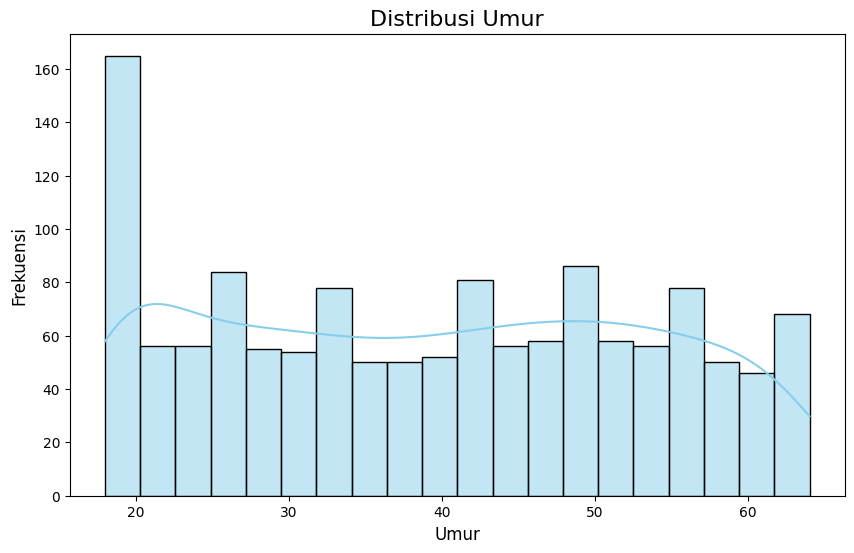

In [282]:
# Misalnya Anda sudah memiliki DataFrame df yang berisi kolom 'age'
# Konversi DataFrame PySpark ke Pandas
df_pandas = df.select("age").toPandas()

# Visualisasi persebaran umur menggunakan histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas["age"], kde=True, bins=20, color="skyblue")

# Menambahkan label dan judul
plt.title("Distribusi Umur", fontsize=16)
plt.xlabel("Umur", fontsize=12)
plt.ylabel("Frekuensi", fontsize=12)

# Menampilkan plot
plt.show()


In [283]:
# Menghitung jumlah kemunculan setiap nilai
result_age = df.groupBy("age").count()

# Mengurutkan berdasarkan jumlah kemunculan (descending) dan mengambil nilai terbanyak

most_frequent = result_age.orderBy(col("count").desc()).first()
print(f"Nilai yang paling sering muncul adalah '{most_frequent['age']}' dengan jumlah {most_frequent['count']}.")

Nilai yang paling sering muncul adalah '18' dengan jumlah 69.


Dari grafik di atas bisa diketahui bahwa nasabah paling banyak berumur sekitar 18 tahun-20 tahun.

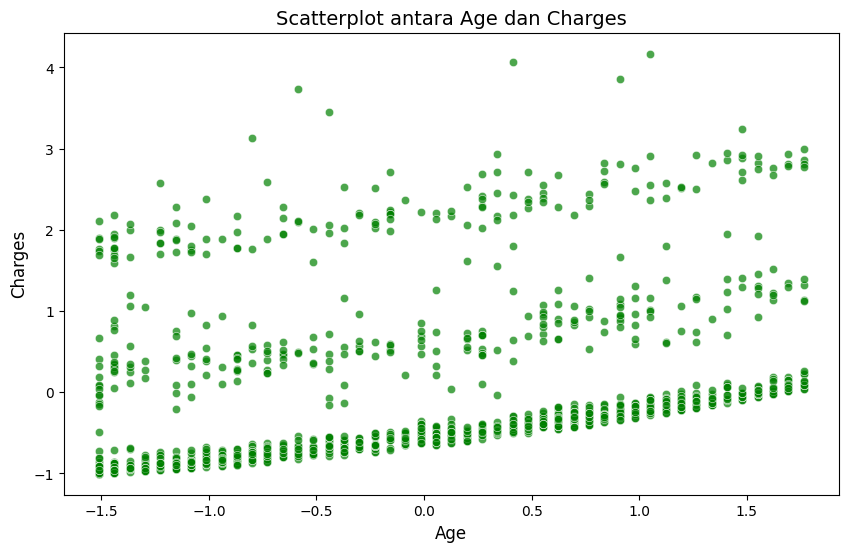

In [ ]:
# Ambil data dari kolom 'age' dan 'charges' dan konversi ke Pandas DataFrame
age_charges_data = df.select("age", "charges").toPandas()

# Membuat scatterplot antara Age dan Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=age_charges_data, x='age', y='charges', color='green', alpha=0.7)

# Menambahkan judul dan label
plt.title("Scatterplot antara Age dan Charges", fontsize=14)
plt.xlabel("Age", fontsize=12)
plt.ylabel("Charges", fontsize=12)

# Menampilkan plot
plt.show()

Dari grafik di atas bisa didapatkan insight bahwa terdapat pola di mana semakin tinggi usia maka biaya asuransi yang ditanggung juga semakin meningkat. Hal ini ditunjukan dengan adanya kemiringan titik-titik data dari kiri bawah ke kanan atas grafik. Meskipun ada tren umum ini, tidak semua individu mengikuti pola yang sama. Ada beberapa orang muda dengan biaya tinggi dan beberapa orang tua dengan biaya rendah.
Hal ini mengindikasikan lemahnya korelasi antara variabel age dengan charges, tetapi masih di angka positif.

In [ ]:
# Menghitung korelasi antara kolom 'age' dan 'charges'
correlation = df.stat.corr("age", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara age dan charges: {correlation}")


Korelasi antara age dan charges: 0.2983082125097871


Bisa dilihat bahwa korelasi antara variabel age dan charges memiliki korelasi yang sangat kecil yaitu di 0.29 sehingga perlu dilakukan penanganan lebih lanjut. Kami disini akan melakukan feature engineering untuk variabel age dengan memberikan label pada umur. Dengan kriteria menurut kemenkes sebagai berikut:
1. 15 sampai 19 tahun (remaja). => label 0
2. 20 sampai 44 tahun (dewasa). => label 1
3. Lebih dari 45 tahun (lansia). => label 2

In [ ]:
def klasifikasi_umur(age):
    if 15<=age<=19:
        return 0
    elif 20<=age<=44:
        return 1
    elif 45<=age:
        return 2
    
# Daftarkan fungsi sebagai UDF
index_udf = udf(klasifikasi_umur, IntegerType())

# Terapkan UDF ke kolom Region untuk membuat kolom baru "Region_Index"
df = df.withColumn("age_Index", index_udf(df["age"]))
df.show()

+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+---------+
|age|   bmi|children|    charges|sex_binary|smoker_binary|Region_Index|    age_standardized|    bmi_standardized|charges_standardized|age_Index|
+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+---------+
| 60|  39.9|       0|  48173.361|         1|            1|           3|  1.4794480646303876|   1.514071973190548|  2.8813545182420937|        2|
| 40|26.315|       1| 6389.37785|         1|            0|           0|0.055386104651389545| -0.7128062085875576| -0.5689132141543524|        1|
| 54|  30.8|       3|   12105.32|         0|            0|           3|  1.0522294766366882|0.022383238985118507|-0.09692540271015385|        2|
| 46|  22.3|       0|   7147.105|         1|            0|           3|   0.482604692645089| -1.3709523918661073| -0.5063447049191

In [ ]:
age = df.groupBy('age_Index').count()
age.show()

+---------+-----+
|age_Index|count|
+---------+-----+
|        1|  672|
|        2|  529|
|        0|  136|
+---------+-----+



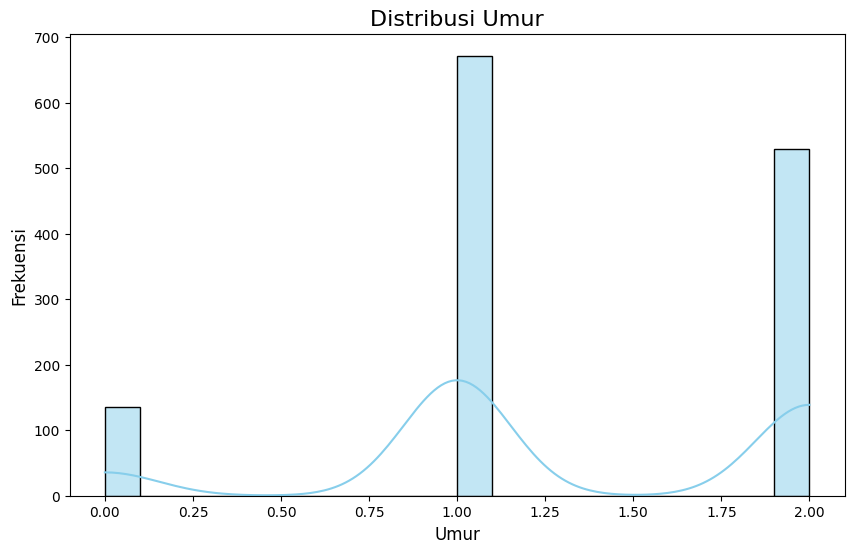

In [ ]:


# Misalnya Anda sudah memiliki DataFrame df yang berisi kolom 'age'
# Konversi DataFrame PySpark ke Pandas
df_pandas = df.select("age_Index").toPandas()

# Visualisasi persebaran umur menggunakan histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_pandas["age_Index"], kde=True, bins=20, color="skyblue")

# Menambahkan label dan judul
plt.title("Distribusi Umur", fontsize=16)
plt.xlabel("Umur", fontsize=12)
plt.ylabel("Frekuensi", fontsize=12)

# Menampilkan plot
plt.show()


In [ ]:
# Menghitung korelasi antara kolom 'age' dan 'charges'
correlation = df.stat.corr("age_Index", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara age dan charges: {correlation}")


Korelasi antara age dan charges: 0.2564945607404583


Nilai korelasi ini lebih kecil dibandingkan sebelumnya sehingga variabel age_Index tidak akan dipakai dan tetap memakai variabel age.

In [ ]:
df = df.drop('age_Index')
df.show()

+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+
|age|   bmi|children|    charges|sex_binary|smoker_binary|Region_Index|    age_standardized|    bmi_standardized|charges_standardized|
+---+------+--------+-----------+----------+-------------+------------+--------------------+--------------------+--------------------+
| 60|  39.9|       0|  48173.361|         1|            1|           3|  1.4794480646303876|   1.514071973190548|  2.8813545182420937|
| 40|26.315|       1| 6389.37785|         1|            0|           0|0.055386104651389545| -0.7128062085875576| -0.5689132141543524|
| 54|  30.8|       3|   12105.32|         0|            0|           3|  1.0522294766366882|0.022383238985118507|-0.09692540271015385|
| 46|  22.3|       0|   7147.105|         1|            0|           3|   0.482604692645089| -1.3709523918661073| -0.5063447049191163|
| 18| 17.29|       2| 12829.4551|         1|           

Kesimpulannya, umur seseorang memiliki pengaruh yang sangat kecil yaitu sekitar 29% untuk nilai charges.

## 2. BMI

In [ ]:
# Menghitung korelasi antara kolom 'age' dan 'charges'
correlation = df.stat.corr("bmi", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara bmi dan charges: {correlation}")


Korelasi antara bmi dan charges: 0.19840083122624957


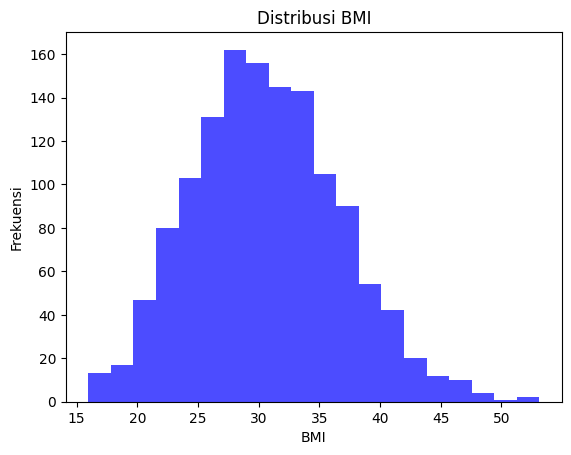

In [ ]:
# Ambil data dari kolom BMI dan konversi ke Pandas DataFrame
bmi_data = df.select("bmi").toPandas()

# Membuat histogram untuk kolom BMI
plt.hist(bmi_data["bmi"], bins=20, color='blue', alpha=0.7)
plt.title("Distribusi BMI")
plt.xlabel("BMI")
plt.ylabel("Frekuensi")
plt.show()


Dari grafik di atas terdapat indikasi outlier dengan BMI di atas 50 di mana rata-rata persebaran data berada di 28-30.

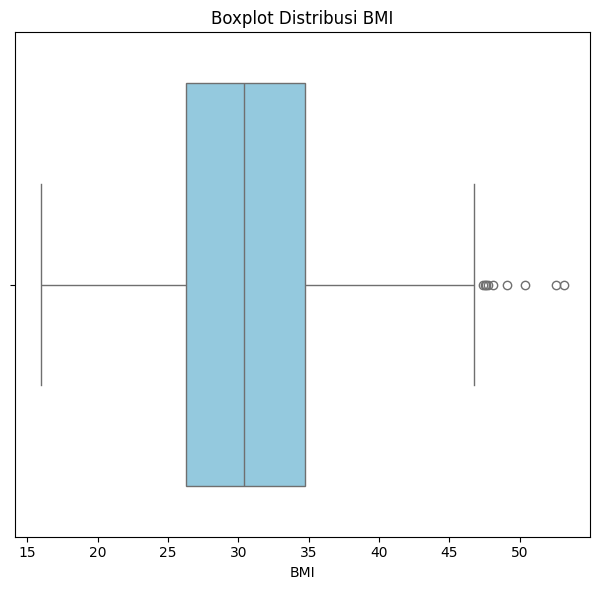

In [ ]:
# Ambil data dari kolom 'age' dan 'charges' dan konversi ke Pandas DataFrame
age_charges_data = df.select("bmi").toPandas()

# Membuat boxplot untuk kolom 'age' dan 'charges'
plt.figure(figsize=(12, 6))

# Boxplot untuk Age
plt.subplot(1, 2, 1)
sns.boxplot(x=age_charges_data["bmi"], color='skyblue')
plt.title("Boxplot Distribusi BMI")
plt.xlabel("BMI")


# Menampilkan plot
plt.tight_layout()
plt.show()


Terdapat outlier pada variabel BMI dengan nilai di atas 45 yang jauh dari mayoritas. Hal ini perlu penanganan lebih lanjut.


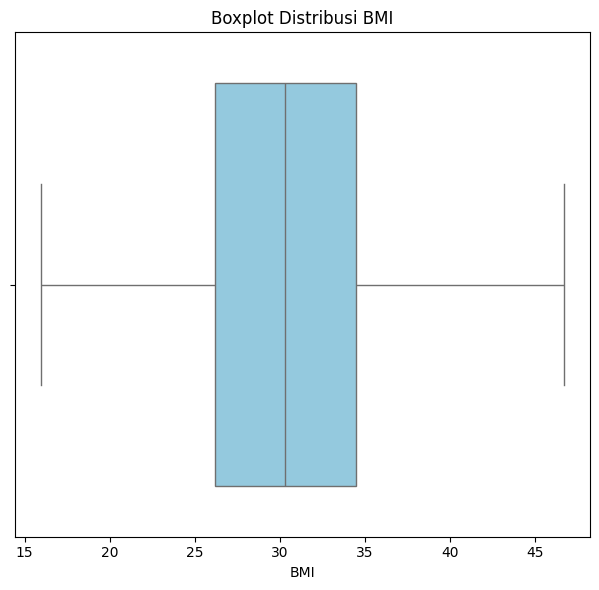

In [ ]:
# Hitung Q1, Q3, dan IQR
quantiles = df.approxQuantile("BMI", [0.25, 0.75], relativeError=0.01)
Q1 = quantiles[0]
Q3 = quantiles[1]
IQR = Q3 - Q1

# Tentukan batas atas dan bawah untuk outlier
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Hapus outlier
df = df.filter((col("bmi") >= lower_bound) & (col("bmi") <= upper_bound))
# Ambil data dari kolom 'age' dan 'charges' dan konversi ke Pandas DataFrame
age_charges_data = df.select("bmi").toPandas()

# Membuat boxplot untuk kolom 'age' dan 'charges'
plt.figure(figsize=(12, 6))

# Boxplot untuk Age
plt.subplot(1, 2, 1)
sns.boxplot(x=age_charges_data["bmi"], color='skyblue')
plt.title("Boxplot Distribusi BMI")
plt.xlabel("BMI")


# Menampilkan plot
plt.tight_layout()
plt.show()

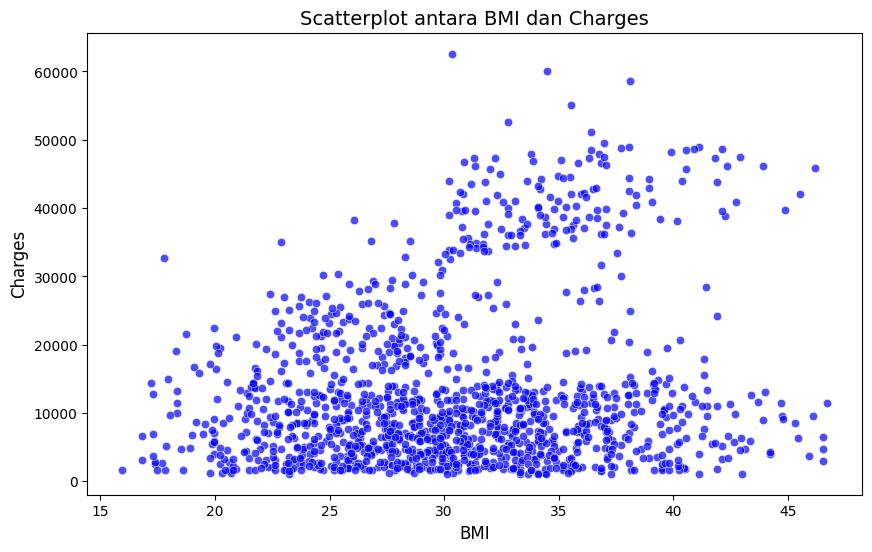

In [ ]:
# Ambil data dari kolom 'bmi' dan 'charges' dan konversi ke Pandas DataFrame
bmi_charges_data = df.select("bmi", "charges").toPandas()

# Membuat scatterplot antara BMI dan Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bmi_charges_data, x='bmi', y='charges', color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title("Scatterplot antara BMI dan Charges", fontsize=14)
plt.xlabel("BMI", fontsize=12)
plt.ylabel("Charges", fontsize=12)

# Menampilkan plot
plt.show()


In [ ]:
# Menghitung korelasi antara kolom 'age' dan 'charges'
correlation = df.stat.corr("bmi", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara bmi dan charges: {correlation}")


Korelasi antara bmi dan charges: 0.19392754790663086


Kesimpulannya, BMI seseorang memiliki pengaruh yang sangat kecil yaitu sekitar 19% untuk nilai charges.

### 3. Children

In [ ]:
correlation = df.stat.corr("children", "charges")

# Menampilkan hasil korelasi
print(f"Korelasi antara children dan charges: {correlation}")


Korelasi antara children dan charges: 0.06952708450520108


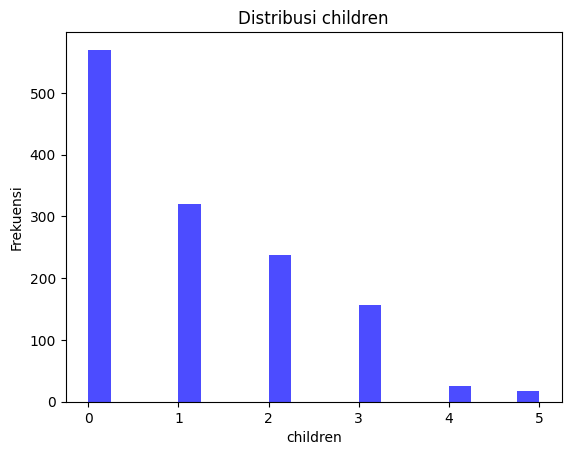

In [ ]:
# Ambil data dari kolom children dan konversi ke Pandas DataFrame
children_data = df.select("children").toPandas()

# Membuat histogram untuk kolom children
plt.hist(children_data["children"], bins=20, color='blue', alpha=0.7)
plt.title("Distribusi children")
plt.xlabel("children")
plt.ylabel("Frekuensi")
plt.show()


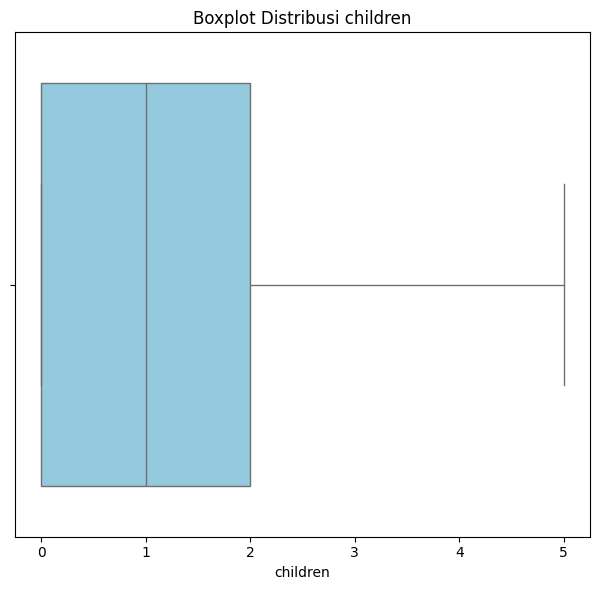

In [ ]:
# Ambil data dari kolom 'age' dan 'charges' dan konversi ke Pandas DataFrame
children_charges = df.select("children").toPandas()

# Membuat boxplot untuk kolom 'age' dan 'charges'
plt.figure(figsize=(12, 6))

# Boxplot untuk Age
plt.subplot(1, 2, 1)
sns.boxplot(x=children_charges["children"], color='skyblue')
plt.title("Boxplot Distribusi children")
plt.xlabel("children")


# Menampilkan plot
plt.tight_layout()
plt.show()


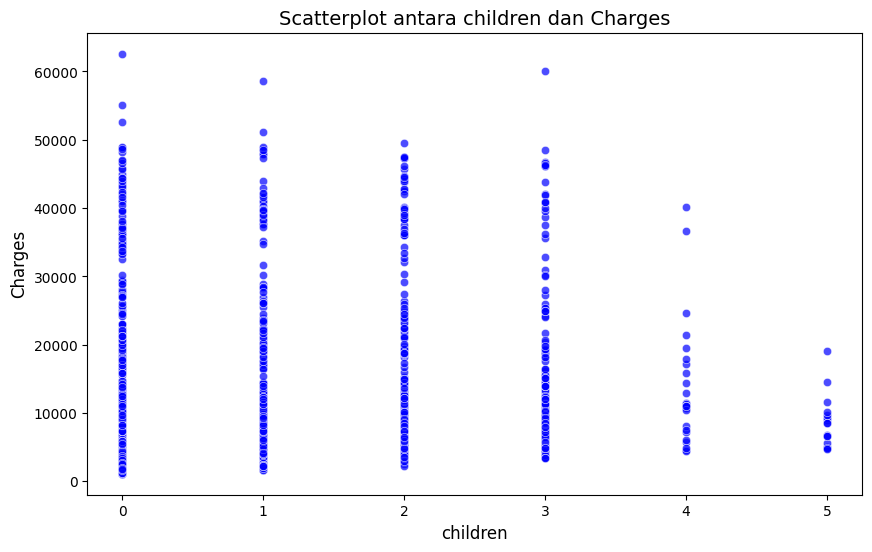

In [ ]:
# Ambil data dari kolom 'children' dan 'charges' dan konversi ke Pandas DataFrame
children_charges_data = df.select("children", "charges").toPandas()

# Membuat scatterplot antara children dan Charges
plt.figure(figsize=(10, 6))
sns.scatterplot(data=children_charges_data, x='children', y='charges', color='blue', alpha=0.7)

# Menambahkan judul dan label
plt.title("Scatterplot antara children dan Charges", fontsize=14)
plt.xlabel("children", fontsize=12)
plt.ylabel("Charges", fontsize=12)

# Menampilkan plot
plt.show()
